# Outsourcing Adjudication to Strategic Jurors

This notebook reproduces the experiments detailed in submission #9941 titled 'Outsourcing Adjudication to Strategic Jurors' to AAAI-23.

## Setup

Run this to setup all functions -- the experiments are found at the bottom 

In [22]:
# Imports
import math
import random
import numpy as np
from numpy.random import binomial
from  matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import time
from datetime import datetime,timedelta
import seaborn as sns; sns.set_theme()

N = 20 # no. samples for estimation

# Construct a settings dict with default settings
def settings(n=20,rho=0.50,alpha=1,epsilon=1,w=2.5,T=50):
    return {
        "n": n,            # number of agents (must be odd)
        "rho": rho,         # fraction of well-informed
        "alpha": alpha,         # effort parameter
        "epsilon": epsilon,    # initial effort
        "w": w,              # payment 
        "T": T
    }

# Setup color map (boilerplate)
def cmap():
    c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.5,0.6,.9,1.]
    l = list(zip(v,c))
    return LinearSegmentedColormap.from_list('rg',l, N=256)

# Reset dynamic programming
def reset():
    mem_q.clear()
    mem_wi.clear()
    mem_br_wi.clear()
    mem_br_mi.clear()

# Compute the exponential function with dynamic programming for efficiency
mem_q = {}
# Compute quality as function of effort
# x: the effort to judge the quality of
def quality(x,S):
    
    # Quick lookup
    if x in mem_q:
        return mem_q[x]
    
    # Using effort function f_i(lambda_i) = 1 - 0.5 * e^(-alpha*lambda_i) if well-informed, and f_i(lambda_i) = 0.5 * e^(-alpha*lambda_i) ow.
    f = 0.5*math.exp(-S["alpha"]*x)
    mem_q[x] = f
    return f

# Sample a signal with effort 'e'
def sample_signal(i, effort, S):
    
    # Compute quality of signal
    f = quality(effort, S)
    
    # Sample signal
    return binomial(1, 1-f if well_informed(i,S) else f)

# Determine verdict from votes
# votes: numpy array of votes in {0,1}
def verdict(votes):
    return 1 if np.sum(votes)>len(votes)/2 else 0 if np.sum(votes)<len(votes)/2 else random.randint(0, 1)

mem_wi = {} # dynamic programming for efficiency
# Determines if a juror is well-informed (by definition, this is the first round(n*rho) jurors)
def well_informed(i, S):
    
    # Quick lookup
    if i in mem_wi:
        return mem_wi[i]
    
    # Compare index
    x = i < np.round(S["n"] * S["rho"])
    mem_wi[i]=x
    return x

mem_br_wi = {} # dynamic programming for efficiency
mem_br_mi = {} # ...
# Determine best response for agent i, given mi as per the note
# mi: Value of m_-i
# i: index of the player
# S: settings dict
def best_response(mi, i, S):
    
    # Quick lookup
    mem_br = mem_br_wi if well_informed(i,S) else mem_br_mi
    
    Q = abs(S["w"] * (1 / (1 + mi) - 1 / (S["n"] - mi)))
    #print(Q)
    
    if i in mem_br:
        return mem_br[i]
    
    # if m_-i = (n-1)/2, then exert no effort
    elif mi == (S["n"]-1) / 2:
        lambdai = 0
        betai = 1
        
    # if m_-i > (n-1)/2, exert effort and vote truthfully (if reward high enough)
    elif mi > (S["n"]-1)/2:
        
        # if payment not sufficiently large, exert zero effort
        if Q <= 2: # -f'_i(0)*w < 1
            lambdai = 0
            betai = 1
            
        # else, exert some effort and answer truthfully iff well-informed
        else:
            lambdai = math.log(Q / 2) #1/S["alpha"] * math.log(S["alpha"]*S["w"] / 2)
            betai = 1 if well_informed(i,S) else 0
            
    # if m_-i < (n-1)/2, exert effort and vote untruthfully (if reward high enough)
    else: #mi < (n-1)/2
        
        # if payment not sufficiently large, exert zero effort
        if Q <= 2:
            lambdai = 0
            betai = 1
            
        # else, exert some effort and answer truthfully iff misinformed
        else:
            lambdai = math.log(Q / 2)#1/S["alpha"] * math.log(S["alpha"]*S["w"] / 2)
            betai = 0 if well_informed(i,S) else 1
    mem_br[i] = (lambdai, betai)
    return lambdai, betai

# Samples one full stage with starting efforts of epsilon
# S: settings dict
def sample_stage(S):       
    # Genesis round
    votes = [sample_signal(i, S["epsilon"], S) for i in range(S["n"])] # all parties use epsilon effort and vote as per their signal
    outcomes = [verdict(votes)] # initialize array of verdicts
    
    # Each subsequent round
    for r in range(S["T"]):
        # Compute votes
        new_votes = []
        for i in range(S["n"]):
            mi = np.sum(votes) - votes[i]                                    # withdraw own contribution to get mi
            lambdai, betai = best_response(mi, i, S)                         # compute best response (as per note)
            signal = sample_signal(i, lambdai, S)                            # sample signal
            new_votes.append(signal if binomial(1,betai) else (1 - signal))  # determine vote
        votes = new_votes                                                    # update 'votes'
        outcomes.append(verdict(votes))                                      # and append verdict
        
    return outcomes

# Estimate the latent correctness for a given set of settings.
# Uses N samples of stages of T rounds to estimate correctness.
# S: settings dict
def estimate_correctness(S):
    # Clear dynamic programming
    reset() 
    
    # compute average correctness in each stage
    avgs = []
    for _ in range(N):
        avgs.append(sample_stage(S))
    
    # ... and take their average
    return np.mean(avgs)

# Format numbers for the heatmap
# x: a number, possibly an int, possibly a float
def rnd(x):
    # if float is an integer
    if round(x) == x or x > 15:
        return int(x)
    
    # else, use one digit
    return np.round(x,1)

# Format time for the progress estimation
# dt: the dt (in seconds)
def format_time(dt):
    # seconds
    if dt < 60:
        x = str(rnd(dt)) # allow decimal seconds
        return x + " sec" + ("s" if x != "1" else "")
    
    # minutes
    elif dt<60*60:
        x = str(math.floor(dt/60)) # compute no. whole minutes
        return x + " min" + ("s" if x != "1" else "") + " " + format_time(dt % 60) # invoke recursively

    # hours
    elif dt<24*60*60:
        x = str(math.floor(dt/(60*60))) # compute no. whole hours
        return x + " hr" + ("s" if x != "1" else "") +" " + format_time(dt % (60*60)) # invoke recursively
        
# Compute a heatmap for a given function
# sets: a map R^2 -> R to plot on a heatmap (specifically, should produce an instance of a settings dict on input (x,y))
# xlabel: label on the x-axis
# ylabel: label on the y-axis
# xrange: minimum and maximum values (incl.) of x
# yrange: minimum and maximum values (incl.) of y
# res: number of samples in each coordinate
def heatmap(sets=lambda x,y: settings(w=x,rho=y,n=100),
            xlabel='Size of reward (w)',
            xrange=[0,2500],
            ylabel='Percentage well-informed (ρ)',
            yrange=[1,0],
            res=-1,
            resx=100,
            resy=20):
    
    if not res == -1:
        resx = res
        resy = res
    
    ticks = resx
    
    # initialize arrays
    xs = np.linspace(xrange[0], xrange[1], num=resx+1)
    ys = np.linspace(yrange[0], yrange[1], num=resy+1)
    X = np.zeros((resy,resx))
    
    # load previous
    #X = np.genfromtxt('out_20_20_15.csv')
    
    # record time
    now = datetime.now()
    print("Starting computation at",now.strftime("%H:%M:%S"))
    before = time.time()
    
    # iterate through x-axis
    if 1==1:
        # case on resolutions to provide most fine-grained time estimation
        for j in range(resx):
            # compute ETA after first iteration
            if j == 1:
                dt = time.time() - before
                timeleft = dt * (resx-1) * 1.025 #* resx / 2
                print("Estimated time left: ", format_time(timeleft))
                now += timedelta(seconds=timeleft)
                print("ETA is",now.strftime("%H:%M:%S"))
                print()
                print("*"*ticks)
                print("*",end='')

            # progress bar
            if j > 1 and np.round(resx/ticks*j) != np.round(resx/ticks*(j+1)):
                print("*",end='')

            # iterate through y-axis
            for i in range(resy):
                #for k in range(N):
                    X[i][j] = estimate_correctness(sets(xs[j],ys[i])) # estimate correctness

    # Save data as CSV
    enddate = datetime.now().strftime("%H:%M:%S")
    np.save("out_"+enddate.replace(":","_")+".npy", X)
    
    # Record when computation finished
    print('*')
    print("Computation finished at",enddate)
    
    # Plot heatmap
    ax=sns.heatmap(X, vmin=0, vmax=1, cmap=cmap())
    ax.set(xlabel=xlabel, ylabel=ylabel,title='Correctness of Adjudication')
    ax.set_xticks([resx/5*i+0.5 for i in range(5)] + [resx])
    ax.set_xticklabels([rnd(xs[int(resx/5*i)]) for i in range(5)] + [rnd(xrange[1])])
    ax.set_yticks([resy/5*i+0.5 for i in range(5)] + [resy])
    ax.set_yticklabels([rnd(ys[int(resy/5*i)]) for i in range(5)] + [rnd(yrange[1])])
    
    
    print()

Starting computation at 02:14:48
Estimated time left:  5 hrs 17 mins 44 secs
ETA is 07:32:32

****************************************************************************************************
****************************************************************************************************
Computation finished at 07:20:11



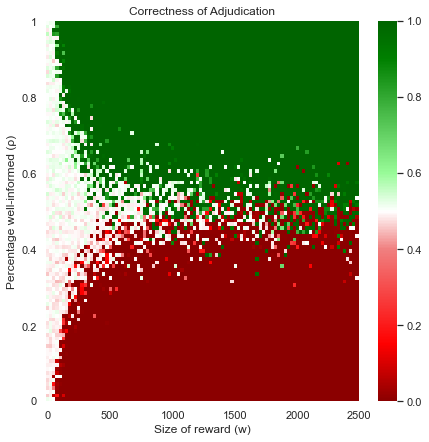

In [23]:
# Set size of figure
plt.subplots(figsize=(7, 7))

# default - plot as function of rho and w
heatmap(res=100)

# plot as function of rho and epsilon
#heatmap(sets = lambda x,y: settings(rho=y, epsilon=x, T=50, w=3,n=100),        # function mapping (x,y) to settings object
#        xlabel = "Initial effort (ɛ)",                                   # Label of x-axis
#        ylabel = "Fraction well-informed (ρ)",                           # Label of y-axis
#        xrange = [0,5],                                                  # range of x-values (incl.)
#        yrange = [1,0],                                                  # range of y-values (incl.)
#        res = 100)                                                       # resolution

# plot as function of T and epsilon
#heatmap(sets = lambda x,y: settings(rho=y, T=int(round(x)), n=100, w=3),  # function mapping (x,y) to settings object
#        xlabel = "Number of rounds (T)",                                  # Label of x-axis
#        ylabel = "Fraction well-informed (ρ)",                            # Label of y-axis
#        xrange = [1,100],                                                 # range of x-values (incl.)
#        yrange = [1,0],                                                   # range of y-values (incl.)
#        res = 100)                                                        # resolution